In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# Lucid Atlas Parameters
# pixel_pitch_mm = 3.45e-3
# focal_length_mm = 8
# baseline_mm = 400
# sensor_width = 6464
# sensor_height = 4852

# Epi Camera Parameters
# pixel_pitch_mm = 0.00375
# focal_length_mm = 4.5
# baseline_mm = 10
# sensor_width = 1280
# sensor_height = 960

# Lucid Triton Parameters
# pixel_pitch_mm = 2.4e-3
# focal_length_mm = 8
# baseline_mm = 100
# sensor_width = 5472
# sensor_height = 3648

# Arducam Parameters
# pixel_pitch_mm = 1.12e-3
# focal_length_mm = 0.76
# baseline_mm = 100
# sensor_width = 3280
# sensor_height = 2464

# Zed 2 Parameters
# pixel_pitch_mm = 2e-3
# focal_length_mm = 2.12
# baseline_mm = 120
# sensor_width = 2688
# sensor_height = 1520

# OAK-D stereo camera parameters
# pixel_pitch_mm = 3e-3
# focal_length_mm = 2.64
# baseline_mm = 75
# sensor_width = 1280
# sensor_height = 800

# OAK-D center RGB camera parameters 
# (NOTE: not a stereo camera pair, these values are here to calculate ability to resolve detail)
# pixel_pitch_mm = 3e-3
# focal_length_mm = 8.8
# baseline_mm = 75 # not used here
# sensor_width = 4032
# sensor_height = 3040

# Realsense D455 Parameters
# pixel_pitch_mm = 3e-3
# focal_length_mm = 1.93
# baseline_mm = 95
# sensor_width = 1280
# sensor_height = 800

# Realsense D455 center RGB parameters
# (NOTE: not a stereo camera pair, these values are here to calculate ability to resolve detail)
# pixel_pitch_mm = 1.4e-3
# focal_length_mm = 1.88
# baseline_mm = 95 # not used here
# sensor_width = 1920
# sensor_height = 1080

# Intel L515 parameters
# NOTE: modeled as stereo pair here but it's actually a LIDAR
# here we model their laser projector + receiver using the same specs as their RGB sensor
# pixel_pitch_mm = 1.4e-3
# focal_length_mm = 1.88
# baseline_mm = 100
# sensor_width = 1080 # switching these because here the baseline displacement is vertical
# sensor_height = 1920

# Go Pro Hero 10 parameters
# pixel_pitch_mm = 1.12e-3
# focal_length_mm = 3
# baseline_mm = 1000
# sensor_width = 5663
# sensor_height = 4223

# Olympus TG6 parameters
pixel_pitch_mm = 1.5e-3
focal_length_mm = 18
baseline_mm = 1000
sensor_width = 4000
sensor_height = 3000

# Computation parameters
disparity_slopes = np.array([-20, -100, -0.05])
display_disparity_slopes = np.array([-10, -1/10])
target_depth_m = 5


$$ z = f \frac{B}{d}$$

where $z$ is the depth, $f$ is the focal length, $B$ is the baseline shift in 1 dimension, and $d$ is the feature disparity.

Since $d$ is in the same units as $z$, $B$, and $f$, we need to convert it to pixels:

$$d = x w$$

where $x$ is the pixel disparity and $w$ is the pixel pitch.

As a result, we get:

$$z = \frac{fB}{xw}$$

The slope of this (depth resolving power in depth/pixel) is given by $$ \frac{\partial z}{\partial x} = -\frac{Bf}{wx^2}$$

We can compute the depth resolving power at a particular depth:
$$\frac{\partial z}{\partial x} = -\frac{wz^2}{fB}$$

We also compute our field of view by $$\theta = 2\tan^{-1}\left(\frac{hw}{2f}\right)$$
where $h$ is the sensor width in pixels, $w$ is the pixel width, $f$ is the focal length

In [21]:
optimal_disparities = np.sqrt((-1 * focal_length_mm * baseline_mm) / (pixel_pitch_mm * disparity_slopes))
display_disparities = np.sqrt((-1 * focal_length_mm * baseline_mm) / (pixel_pitch_mm * display_disparity_slopes))

optimal_depths_mm = focal_length_mm * baseline_mm / (optimal_disparities * pixel_pitch_mm)


pixel_disparity = np.linspace(display_disparities[0], display_disparities[1], num=256)

disparity_depth_mm = focal_length_mm * baseline_mm / (pixel_disparity * pixel_pitch_mm)

hfov = np.rad2deg(2 * np.arctan2(sensor_width * pixel_pitch_mm, 2 * focal_length_mm))
vfov = np.rad2deg(2 * np.arctan2(sensor_height * pixel_pitch_mm, 2 * focal_length_mm))

minimum_objective_distance = focal_length_mm * baseline_mm / (pixel_pitch_mm * sensor_width)

target_depth_error = -1 * pixel_pitch_mm * (target_depth_m * 1e3)**2  / (focal_length_mm * baseline_mm)


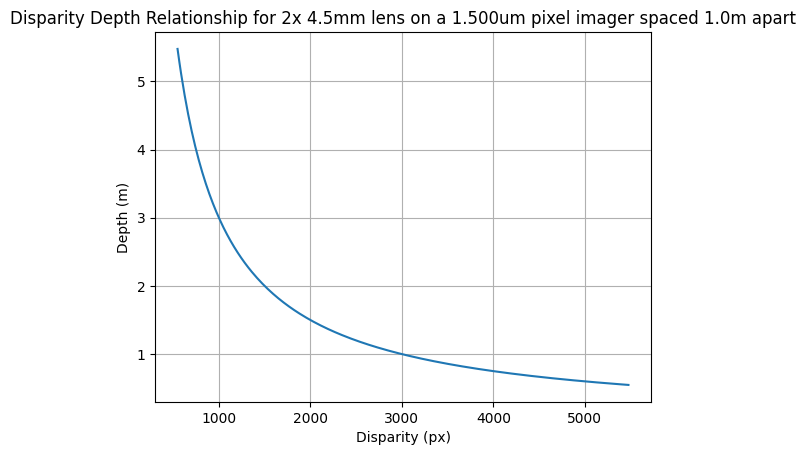

In [22]:
plt.plot(pixel_disparity, disparity_depth_mm / 1e3)
plt.xlabel("Disparity (px)")
plt.ylabel("Depth (m)")
plt.title(f"Disparity Depth Relationship for 2x {focal_length_mm}mm lens on a {pixel_pitch_mm * 1e3:.3f}um pixel imager spaced {baseline_mm/1000}m apart")
plt.grid()


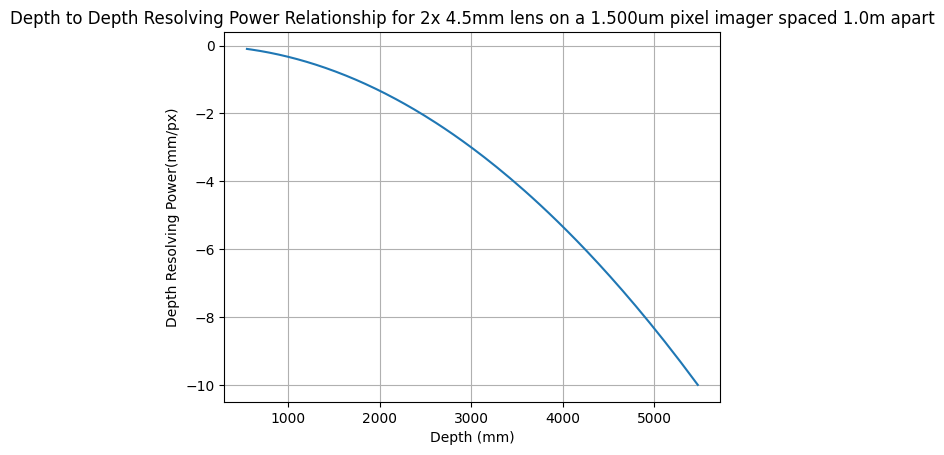

In [23]:
plt.plot(disparity_depth_mm, -1 * (pixel_pitch_mm * disparity_depth_mm**2)/(baseline_mm * focal_length_mm))
plt.xlabel("Depth (mm)")
plt.ylabel("Depth Resolving Power(mm/px)")
plt.title(f"Depth to Depth Resolving Power Relationship for 2x {focal_length_mm}mm lens on a {pixel_pitch_mm * 1e3:.3f}um pixel imager spaced {baseline_mm/1000}m apart")
plt.grid()


In [24]:
print(f'Horizontal Field of View: {hfov:.0f} degrees')
print(f'Vertical Field of View: {vfov:.0f} degrees')
print(f'The optimal resolving depth is {optimal_depths_mm[0]/1e3:.3f} m, preferably between {optimal_depths_mm[1]/1e3:.3f} m and {optimal_depths_mm[2]/1e3:.3f} m')
print(f'The corresponding disparities are {optimal_disparities[0]:.0f} px, {optimal_disparities[1]:.0f} px, and {optimal_disparities[2]:.0f} px')
print(f'The corresponding resolving powers are {disparity_slopes[0]:.1f} mm/px, {disparity_slopes[1]:.1f} mm/px, and {disparity_slopes[2]:.1f} mm/px')
print(f'The minimum resolvable depth is {minimum_objective_distance:.0f} mm')
print(f'The depth error at the target depth of {target_depth_m} m is {target_depth_error} mm/px')

Horizontal Field of View: 67 degrees
Vertical Field of View: 53 degrees
The optimal resolving depth is 7.746 m, preferably between 17.321 m and 0.387 m
The corresponding disparities are 387 px, 173 px, and 7746 px
The corresponding resolving powers are -20.0 mm/px, -100.0 mm/px, and -0.1 mm/px
The minimum resolvable depth is 750 mm
The depth error at the target depth of 5 m is -8.333333333333334 mm/px


Below are calculations for the distance that one pixel corresponds to on an object at the target distance. From similar triangles we know that
$$\frac{D}{z} = \frac{hw}{f},$$
where $D$ is the horizontal distance along the plane at distance $z$ away from the camera that is captured in the image. We can then divide by the sensor width to get the corresponding distance on an object at distance z per pixel: 
$$x_{pixel} = \frac{D}{h} = \frac{wz}{f}$$

In [25]:
target_pixel_dist_on_object_mm = (pixel_pitch_mm * target_depth_m * 1e3 )/focal_length_mm
depth_axis_m = np.linspace(0.2, 10, num=256)
pixel_dist_on_object_mm = (pixel_pitch_mm * depth_axis_m * 1e3 )/focal_length_mm

In [26]:
print(f'Size of a single pixel on object at {target_depth_m}m: {target_pixel_dist_on_object_mm:.3f}mm')

Size of a single pixel on object at 5m: 1.667mm


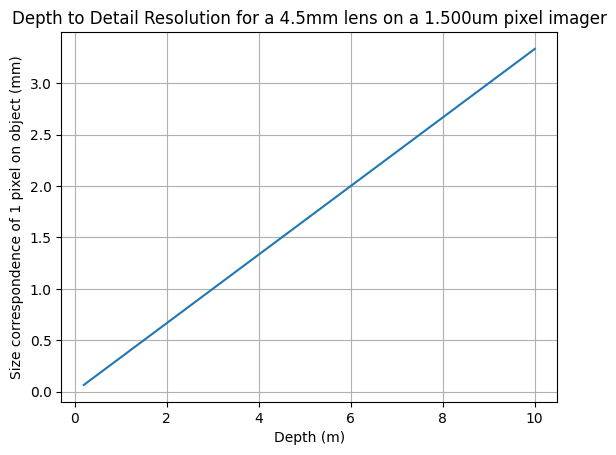

In [27]:
plt.plot(depth_axis_m, pixel_dist_on_object_mm)
plt.xlabel("Depth (m)")
plt.ylabel("Size correspondence of 1 pixel on object (mm)")
plt.title(f"Depth to Detail Resolution for a {focal_length_mm}mm lens on a {pixel_pitch_mm * 1e3:.3f}um pixel imager")
plt.grid()